# Mean Reversion Backtest

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline

In [2]:
plt.style.use('seaborn')

/var/folders/9z/mvzm9dhd5c3dzy6mdkxzhf_c0000gn/T/ipykernel_20206/240305066.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Mean reversion trading is such that if a stationary time series goes too far from his trend, then we short it and vice versa. The stationary time series used for the strategy can be calculate with various way. Here, we will use the deviation of the stock price from an SMA.  

In [3]:
# Download the data
start = '2020-01-01'
end = '2025-05-01'

btc = yf.download(tickers='BTC-USD', start=start, end=end)
btc.columns = ['close', 'high', 'low', 'open', 'volumne']
print(btc.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

                  close         high          low         open      volumne
Date                                                                       
2020-01-01  7200.174316  7254.330566  7174.944336  7194.892090  18565664997
2020-01-02  6985.470215  7212.155273  6935.270020  7202.551270  20802083465
2020-01-03  7344.884277  7413.715332  6914.996094  6984.428711  28111481032
2020-01-04  7410.656738  7427.385742  7309.514160  7345.375488  18444271275
2020-01-05  7411.317383  7544.497070  7400.535645  7410.451660  19725074095


In [4]:
# set up the dataset
df = pd.DataFrame(btc['close'].copy())

# compute the log returns
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

In [6]:
# compute the sma and the diff between the price and the sma
df['sma'] = df['close'].rolling(24).mean()
df['difference'] = df['close'] - df['sma']
print(df.tail())

                   close  log_returns           sma   difference
Date                                                            
2025-04-26  94646.929688    -0.000777  85356.286458  9290.643229
2025-04-27  93754.843750    -0.009470  85800.120443  7954.723307
2025-04-28  94978.750000     0.012970  86264.076497  8714.673503
2025-04-29  94284.789062    -0.007333  86713.242839  7571.546224
2025-04-30  94207.312500    -0.000822  87379.610677  6827.701823


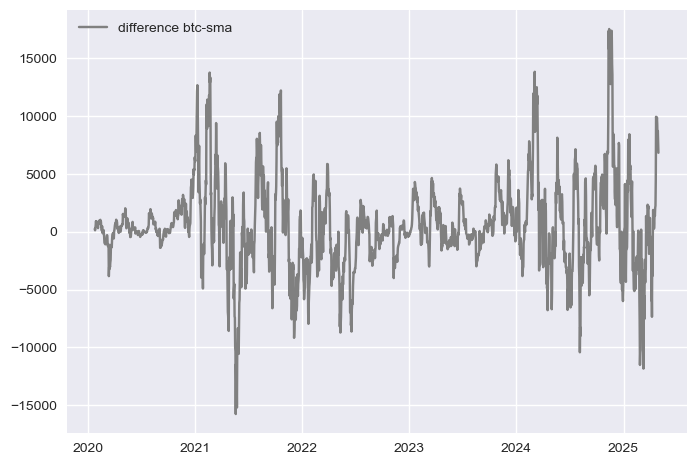

In [7]:
fig, ax = plt.subplots(1, 1)
ax.plot(df['difference'], c='gray', label='difference btc-sma')
ax.legend()

We can normalize the data. 

In [8]:
df['norm_diff'] = (df['difference'] - df['difference'].mean()) / df['difference'].std()
print(df.tail()) 

                   close  log_returns           sma   difference  norm_diff
Date                                                                       
2025-04-26  94646.929688    -0.000777  85356.286458  9290.643229   2.322144
2025-04-27  93754.843750    -0.009470  85800.120443  7954.723307   1.969614
2025-04-28  94978.750000     0.012970  86264.076497  8714.673503   2.170154
2025-04-29  94284.789062    -0.007333  86713.242839  7571.546224   1.868499
2025-04-30  94207.312500    -0.000822  87379.610677  6827.701823   1.672209


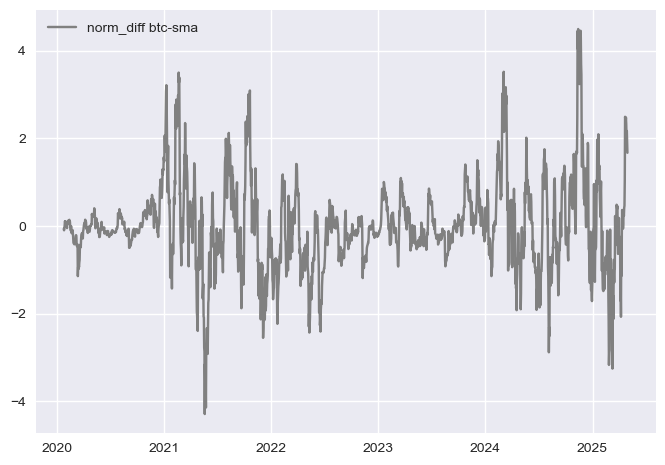

In [9]:
fig, ax = plt.subplots(1, 1)
ax.plot(df['norm_diff'], c='gray', label='norm_diff btc-sma')
ax.legend()

We need to define a threshold that determines if we take a trade or not. If the time series "norm_diff" is above the threshold, then we short the asset and if it is below -threshold, then we long the asset.

In [22]:
threshold = 2
df['position'] = np.where(df['norm_diff'] > threshold, -1, np.nan)
df['position'] = np.where(df['norm_diff'] < -threshold, 1, df['position'])
df['position'] = np.where(df['norm_diff'] * df['norm_diff'].shift(1) < 0, 0, df['position'])
df['position'] = df['position'].ffill().fillna(0)

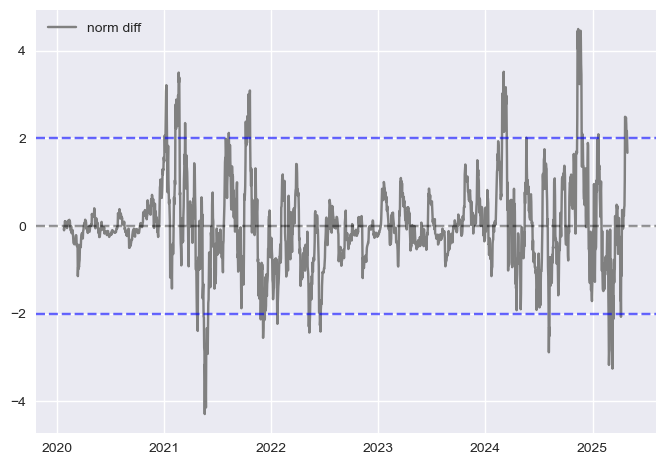

In [31]:
fig, ax = plt.subplots(1, 1)
ax.plot(df['norm_diff'], c='gray', label='norm diff')
ax.axhline(threshold, c='blue', ls='--', alpha=0.6)
ax.axhline(-threshold, c='blue', ls='--', alpha=0.6)
ax.axhline(0, c='black', ls='--', alpha=0.4)
ax.legend()

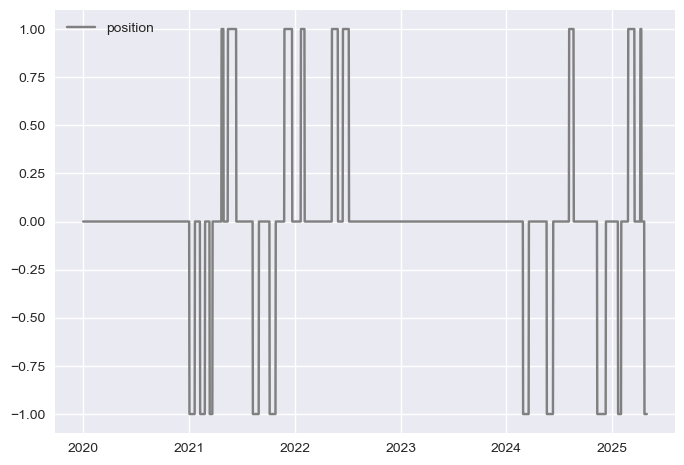

In [24]:
fig, ax = plt.subplots(1, 1)
ax.plot(df['position'], c='gray', label='position')
ax.legend()

In [32]:
df['strategy'] = df['position'].shift(1) * df['log_returns']
df[['log_returns', 'strategy']].sum().apply(np.exp)

log_returns    13.084032
strategy        1.456269
dtype: float64

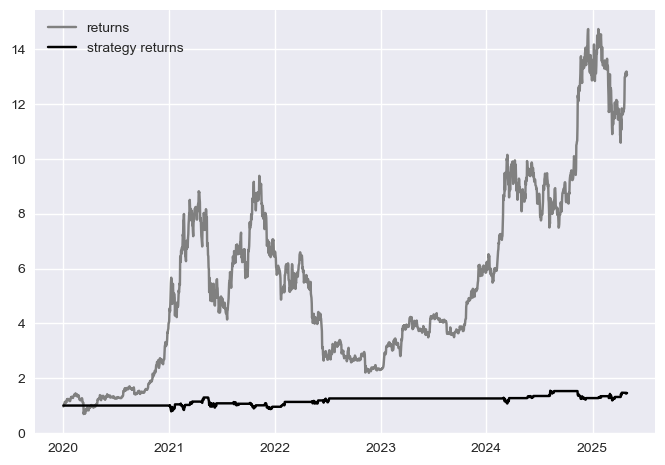

In [33]:
# let's plot the evolution of the returns
fig, ax = plt.subplots(1, 1)
ax.plot(df['log_returns'].cumsum().apply(np.exp), label='returns', c='gray')
ax.plot(df['strategy'].cumsum().apply(np.exp), label='strategy returns', c='black')
ax.legend()